## Import packages

In [1]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import imutils
import matplotlib.pyplot as plt

## Function declaration

Jupyter Notebook 및 Google Colab에서 이미지를 표시할 수 있도록 Function으로 정의

In [2]:
def img_show(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

color 를 판단하는 Function

In [14]:
def color_label(image, c):
    # 윤곽선에 대한 마스크를 구성한 다음 영역에 대한 평균 L*a*b* 값을 계산
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)
    mean = cv2.mean(image, mask=mask)[:3]
    
    # 정의한 색상 L*a*b* Array를 loop로 수행하여 L*a*b* 색상 값과 이미지 평균 사이의 거리를 계산하며 
    # 최소 거리의 L*a*b* 색상 값을 찾음
    min_dist = (np.inf, None)

    for (i, row) in enumerate(lab_array):
        d = dist.euclidean(row[0], mean)
        if d < min_dist[0]:
            min_dist = (d, i)
    
    return color_names[min_dist[1]]

## Load Image

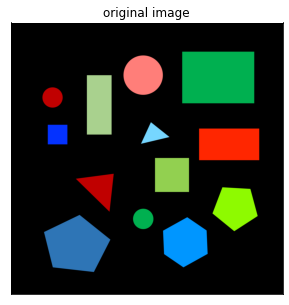

In [4]:
cv2_image = cv2.imread('asset/images/color.jpg', cv2.IMREAD_COLOR)
img_show('original image', cv2_image)

## Color Detection

Key는 색상명, Value는 RGB값을 tuple로 색상 dictionary를 정의합니다.

In [5]:
colors_dict = {"Red": (255, 0, 0),
               "Green": (0, 255, 0),
               "Blue": (0, 0, 255),
               "Lite blue": (118, 214, 255),
               "Moderate green": (146, 208, 80),
               "Dark green": (0, 176, 80),
               "Light red": (255, 126, 121),}

RGB color space를 ```L*a*b*``` color space로 변환

In [6]:
lab_array = np.zeros((len(colors_dict), 1, 3), dtype="uint8")
color_names = []

for (i, (name, rgb)) in enumerate(colors_dict.items()):
    lab_array[i] = rgb
    color_names.append(name)
    
lab_array = cv2.cvtColor(lab_array, cv2.COLOR_RGB2LAB)

아래 과정을 통해 이미지를 그레이스케일로 변환하고 노이즈를 줄이기 위한 이미지 블러링 후 이진화 합니다.

In [7]:
resized = imutils.resize(cv2_image, width=640)
ratio = cv2_image.shape[0] / float(resized.shape[0])
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
lab_img = cv2.cvtColor(blurred, cv2.COLOR_BGR2LAB)
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]

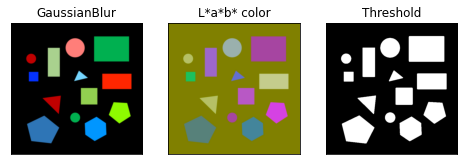

In [8]:
img_show(['GaussianBlur', 'L*a*b* color', 'Threshold'], [blurred, lab_img, thresh])

이진화 이미지에서 윤곽선을 검출합니다.

In [9]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [15]:
vis = cv2_image.copy()

# loop over the contours
for c in cnts:
    # cv2.moments를 이용하여 객체의 중심을 계산
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    
    # 이미지에서 객체의 윤곽선과 Color를 표시
    color = color_label(lab_img, c)

    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(vis, [c], -1, (0, 255, 0), 10)
    cv2.circle(vis, (cX, cY), 20, (0, 255, 0), -1); 
    cv2.putText(vis, color, (cX-80, cY-50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)

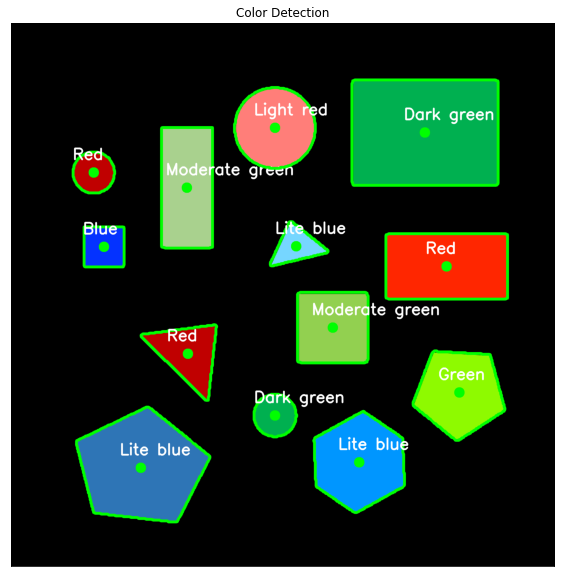

In [11]:
img_show('Color Detection', vis, figsize=(16,10))